In [8]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
# from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [9]:
# tỉ lệ 9:1
df = pd.read_csv('NVL Historical Data 1_6.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df['Price'].str.replace(',', '')
# Chuyển sang dạng số
df = pd.to_numeric(df)
df = df[::-1]

df = df.reset_index(drop=True) # Reset the index

In [10]:
scaler = StandardScaler()
df1 = scaler.fit_transform(np.array(df).reshape(-1, 1))


In [11]:
# Assuming df is your DataFrame containing your data
train_size = int(0.9 * len(df))

# Split the data into training and testing sets
train_data = df1[:train_size]
test_data = df1[train_size:]



In [12]:
train_data
test_data.shape

(160, 1)

In [13]:
# !pip install tbats

In [14]:
from tbats import BATS, TBATS
# 3. Quá trình Training
y_train = np.array(train_data)

estimator = TBATS(
    seasonal_periods=[12, 30.25],
    use_arma_errors=True,
    use_box_cox=True
)
model = estimator.fit(y_train)


In [15]:
# 4. Quá trình testing
y_test = np.array(test_data)
y_pred =  model.forecast(steps=190)

In [16]:
print(y_pred[-30:])

[-1.25597248 -1.25597279 -1.25597308 -1.25597335 -1.2559736  -1.25597384
 -1.25597407 -1.25597428 -1.25597448 -1.25597467 -1.25597484 -1.25597501
 -1.25597516 -1.25597531 -1.25597545 -1.25597558 -1.2559757  -1.25597581
 -1.25597592 -1.25597602 -1.25597612 -1.25597621 -1.25597629 -1.25597637
 -1.25597644 -1.25597651 -1.25597658 -1.25597664 -1.2559767  -1.25597675]


In [17]:

y_next_30_days = y_pred[-30:]
y_pred = y_pred[:160]
print(y_pred)
print(y_next_30_days)

[-1.15622947 -1.16220019 -1.16781352 -1.17309084 -1.17805228 -1.18271673
 -1.18710198 -1.19122473 -1.19510071 -1.19874467 -1.20217052 -1.2053913
 -1.2084193  -1.21126604 -1.21394239 -1.21645853 -1.21882406 -1.221048
 -1.22313881 -1.22510448 -1.22695248 -1.22868986 -1.23032325 -1.23185887
 -1.23330257 -1.23465985 -1.23593589 -1.23713555 -1.23826339 -1.23932373
 -1.2403206  -1.24125779 -1.24213889 -1.24296725 -1.24374602 -1.24447818
 -1.24516651 -1.24581364 -1.24642204 -1.24699402 -1.24753176 -1.24803731
 -1.2485126  -1.24895944 -1.24937953 -1.24977448 -1.25014579 -1.25049487
 -1.25082305 -1.25113159 -1.25142167 -1.25169438 -1.25195076 -1.2521918
 -1.25241841 -1.25263146 -1.25283175 -1.25302006 -1.25319709 -1.25336353
 -1.25352    -1.25366711 -1.25380541 -1.25393543 -1.25405767 -1.2541726
 -1.25428064 -1.25438222 -1.25447771 -1.2545675  -1.2546519  -1.25473126
 -1.25480586 -1.254876   -1.25494194 -1.25500393 -1.25506221 -1.25511701
 -1.25516852 -1.25521695 -1.25526248 -1.25530529 -1.2553

In [18]:
train_data = df[:train_size]
test_data = df[train_size:]
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_next_30_days = scaler.inverse_transform(y_next_30_days.reshape(-1, 1))


In [19]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 4402.613554223727
RMSE: 4732.263453110199
MAPE: 0.2657178325724382


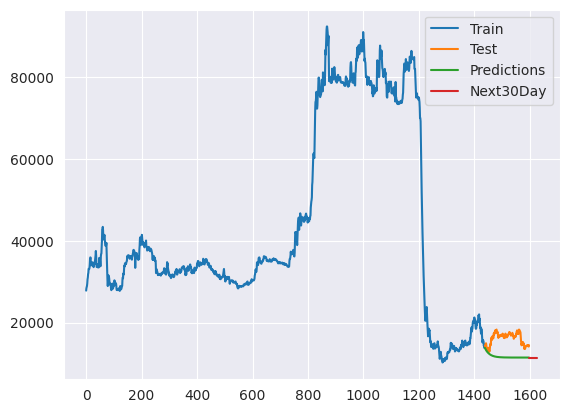

In [20]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()